In [1]:
import test_config as cfg
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import os, os.path
import pickle
import io

import skimage
import skimage.io, skimage.transform, skimage.filters
import scipy.ndimage

import sys
sys.path.append(r'../src/')

import importlib
import transform
import filters
import local_radon
importlib.reload(transform)
importlib.reload(filters)
importlib.reload(local_radon)

<module 'local_radon' from '../src\\local_radon.py'>

D:/Data/bujo_sample\20190309_125151.jpg
Wall time: 1.03 s


C:\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


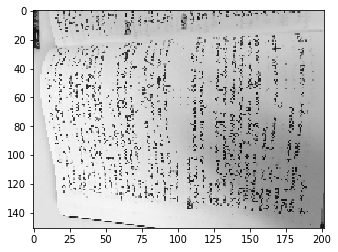

In [2]:
%%time
src_fname = os.path.join(cfg.sample_path, os.listdir(cfg.sample_path)[6])
print(src_fname)
src = skimage.io.imread(src_fname, as_grey=True)

src2 = skimage.transform.rescale(src, scale=0.05)
plt.imshow(src2, cmap='gray')

C:\Anaconda3\lib\site-packages\skimage\transform\radon_transform.py:69: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
C:\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Text angles is 0.0
Text line delta is 9
Wall time: 890 ms


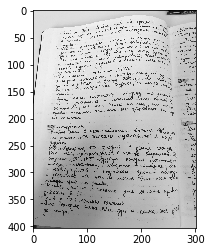

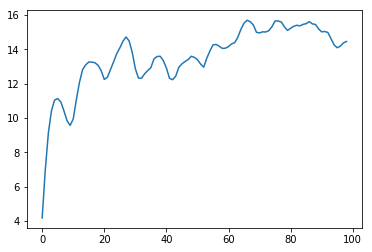

In [3]:
%%time
text_angle = transform.get_text_angle(src2)
print('Text angles is {}'.format(text_angle[0][0]))

src3 = skimage.transform.rotate(skimage.transform.rescale(src, scale=0.1), -90.0-text_angle[0][0], resize=True)
srcr = skimage.transform.rotate(src, -90.0-text_angle[0][0], resize=True)
plt.figure()
plt.imshow(src3, cmap='gray')

text_line_delta, text_line_deltas = transform.get_text_line_delta(src3)
plt.figure()
plt.plot(text_line_deltas)
print('Text line delta is {}'.format(text_line_delta))

Wall time: 77.7 ms


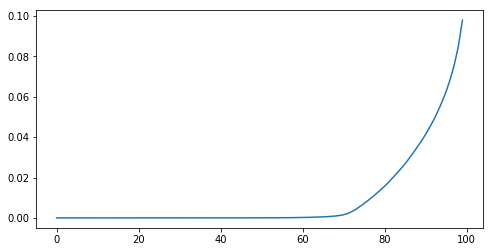

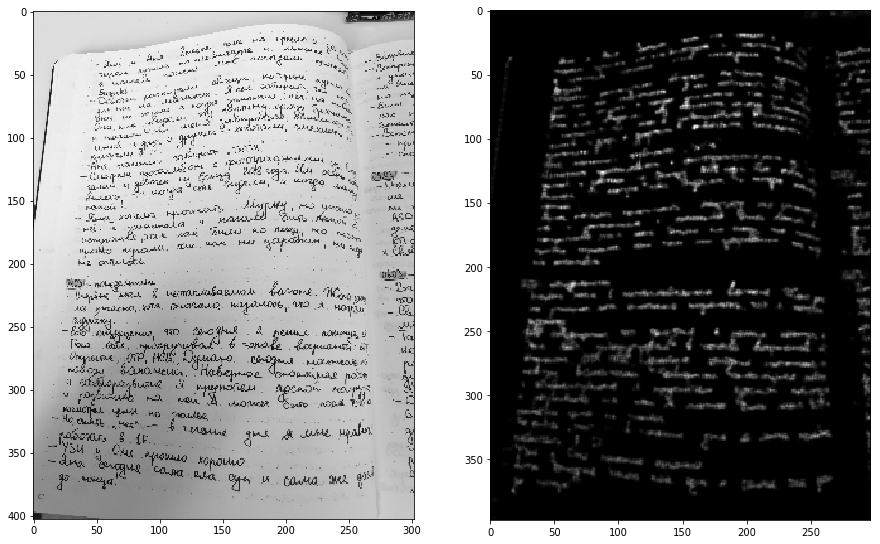

In [4]:
%%time
src4 = transform.filter_variance(src3, (text_line_delta//2, text_line_delta//2), 50, 50)
text_cutoff = np.percentile(src4, 90)/2

plt.figure(figsize=(8,4))
plt.plot(np.percentile(src4, range(100)))

plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(src3, cmap='gray')
plt.subplot(122)
plt.imshow(src4, cmap='gray')

C:\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[(-1.5466302294595904, -64.0, 0, 162, 1677)]
Wall time: 109 ms


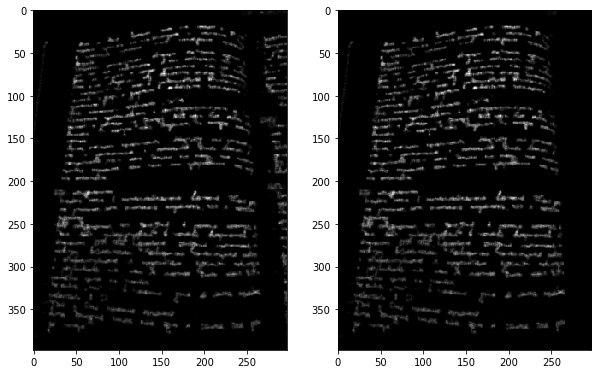

In [5]:
%%time
src5 = skimage.transform.rescale(src4>text_cutoff, scale=0.25)>0.0
src6 = skimage.filters.gaussian(src5, sigma=0.2)>0.4

vsplits = transform.search_region_vsplit(src6, np.pi*3/8, num_angles=131,
                                         window_size_1d=15, max_value=2, zero_threshold=10,
                                         min_split_abs=100, max_split_pct=0.10)

src7 = transform.erase_regions(src4, vsplits, dsz=4)
print(vsplits)

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(src4, cmap='gray')
plt.subplot(122)
plt.imshow(src7, cmap='gray')

Wall time: 228 ms


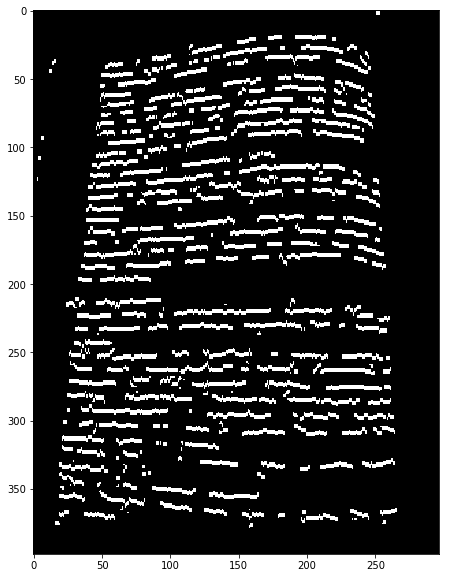

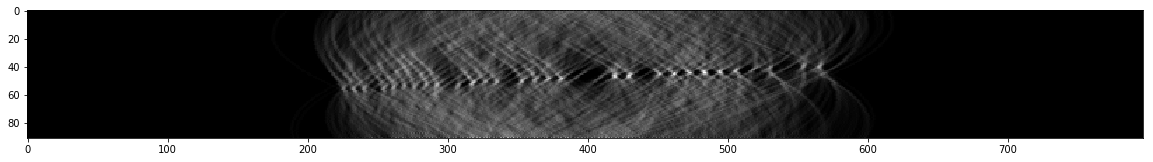

In [6]:
%%time
src8 = filters.local_maxima_v(src7, 1, text_line_delta//2, text_cutoff)*1.0

theta = np.linspace(-np.pi/4, np.pi/4, 91)
rgrid = local_radon.create_grid(src8, theta)
src9 = local_radon.calc_local_radon(rgrid, src8, 0, src8.shape[0], 0, src8.shape[1])

plt.figure(figsize=(8,10))
plt.imshow(src8, cmap='gray')

plt.figure(figsize=(20,10))
plt.imshow(src9, cmap='gray')

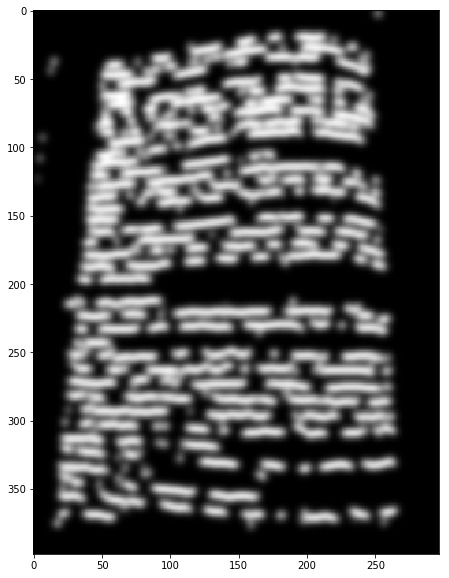

In [53]:
tmp1 = skimage.filters.gaussian(src8, sigma=3)

plt.figure(figsize=(8,10))
plt.imshow(tmp1, cmap='gray')

In [54]:
%%time
tmp1x = skimage.filters.sobel_h(tmp1)
tmp1y = skimage.filters.sobel_v(tmp1)

tmp2 = np.array([tmp1x * np.cos(tst_angle) + tmp1y * np.sin(tst_angle) for tst_angle in theta])

Wall time: 93.7 ms


In [27]:
import skimage.morphology

In [55]:
%%time
tmp3 = np.array([skimage.filters.rank.mean(tmp2[i,:,:], skimage.morphology.disk(20)) for i in range(tmp2.shape[0])])

C:\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Wall time: 5.78 s


In [34]:
tmp2.shape, tmp3.shape

((91, 398, 297), (91, 398, 297))

In [56]:
tmp4 = np.argmax(tmp3, axis=0)

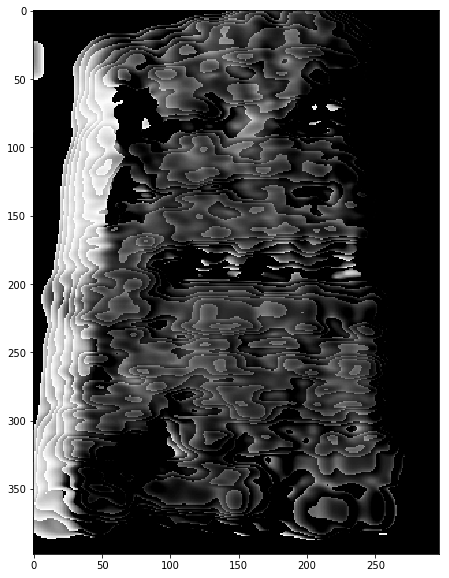

In [57]:
plt.figure(figsize=(20,10))
plt.imshow(tmp4, cmap='gray')

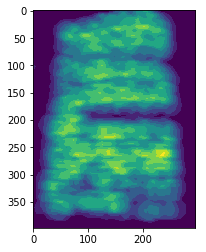

In [58]:
plt.imshow(tmp3[41])